<a id='start'></a>
<h1><center>WiDS Datathon 2022</center></h1>
<h2>Overview</h2>
<hr></hr>
The WiDS Datathon dataset was created in collaboration with Climate Change AI (CCAI) and Lawrence Berkeley National Laboratory (Berkeley Lab). WiDS Datathon participants will analyze differences in building energy efficiency, creating models to predict building energy consumption.
<h2>Agenda</h2>
<hr></hr>
<ol>
<li><a href='#eda'>EDA: Understand the Missing Values</a></li>
<li><a href='#features'>Feature Engineering</a></li>
<li><a href='#methods'>Impute Missing Data </a></li>  
<li><a href='#models'>Model Development</a> </li>  
</ol>

In [1273]:
#Loading the relevant libraries 
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from collections import deque
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm, cv
import shap

In [639]:
#Reading the data
train_1 = pd.read_csv('train.csv')

train_1.set_index('id',inplace=True)

train_1.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
id,,,,,,,,,,,,,,,,,,,,,
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395


In [640]:
train_1.shape

(75757, 63)

In [1099]:
train, test = train_test_split(train_1.copy(), test_size=0.10, random_state=42)
train.shape, test.shape

((68181, 63), (7576, 63))

<a id='eda'></a>
# SECTION 1: Understand the Missing Values

In [859]:
#Summary stats for just numeric data 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train.describe(include=numerics)

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
count,68181.000000,6.818100e+04,66518.000000,52097.000000,68181.000000,68181.000000,68181.000000,68181.000000,68181.000000,68181.000000,...,68181.000000,68181.000000,68181.000000,68181.000000,68181.000000,31160.000000,30497.000000,31160.000000,26957.000000,68181.000000
mean,4.368138,1.656863e+05,1952.277970,60.325461,39.443063,11.443584,34.320136,59.065649,11.730658,35.539703,...,0.872662,82.723647,14.072777,0.281413,0.002464,66.410655,62.585238,4.185863,109.138962,82.539225
std,1.471593,2.455663e+05,36.701928,27.131682,60.777854,9.382101,6.999289,5.361491,12.577462,8.868161,...,2.878019,25.296486,10.954215,2.248625,0.144499,131.026179,130.143274,6.457079,50.613141,58.122484
min,1.000000,9.430000e+02,0.000000,-0.583647,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169
25%,3.000000,6.235000e+04,1927.000000,42.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,...,0.000000,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.523363
50%,5.000000,9.117000e+04,1951.000000,64.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,...,0.000000,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716
75%,6.000000,1.658380e+05,1977.000000,83.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,...,0.000000,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.221817
max,6.000000,6.385382e+06,2015.000000,105.662449,1924.500000,49.000000,64.758065,90.000000,48.000000,65.107143,...,31.000000,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120


**We can see that there are 0s in year_built that should probably be converted to NaN. So let's do that.**

In [860]:
#Replace 0s in the year_built with np.nan
train = train.replace({'year_built': 0}, value = np.nan)

In [861]:
#Get the classes in each categorical variable
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
for col in cat_cols:
    print (col,":", train[col].unique())

facility_type : ['Multifamily_Uncategorized' 'Mixed_Use_Predominantly_Residential'
 'Lodging_Hotel' 'Office_Uncategorized' 'Education_Other_classroom'
 'Warehouse_Distribution_or_Shipping_center' 'Retail_Uncategorized'
 'Warehouse_Nonrefrigerated' 'Food_Service_Other' '2to4_Unit_Building'
 'Warehouse_Selfstorage' 'Health_Care_Inpatient'
 'Public_Safety_Penitentiary' 'Commercial_Other' 'Public_Assembly_Other'
 '5plus_Unit_Building' 'Education_College_or_university'
 'Lodging_Dormitory_or_fraternity_sorority'
 'Retail_Vehicle_dealership_showroom' 'Office_Medical_non_diagnostic'
 'Public_Safety_Fire_or_police_station'
 'Mixed_Use_Commercial_and_Residential' 'Grocery_store_or_food_market'
 'Industrial' 'Religious_worship' 'Education_Uncategorized' 'Nursing_Home'
 'Warehouse_Uncategorized' 'Retail_Enclosed_mall'
 'Food_Service_Uncategorized' 'Commercial_Unknown' 'Parking_Garage'
 'Mixed_Use_Predominantly_Commercial' 'Laboratory' 'Lodging_Other'
 'Health_Care_Uncategorized' 'Public_Assembly_

**Now let's plot the missing data.**

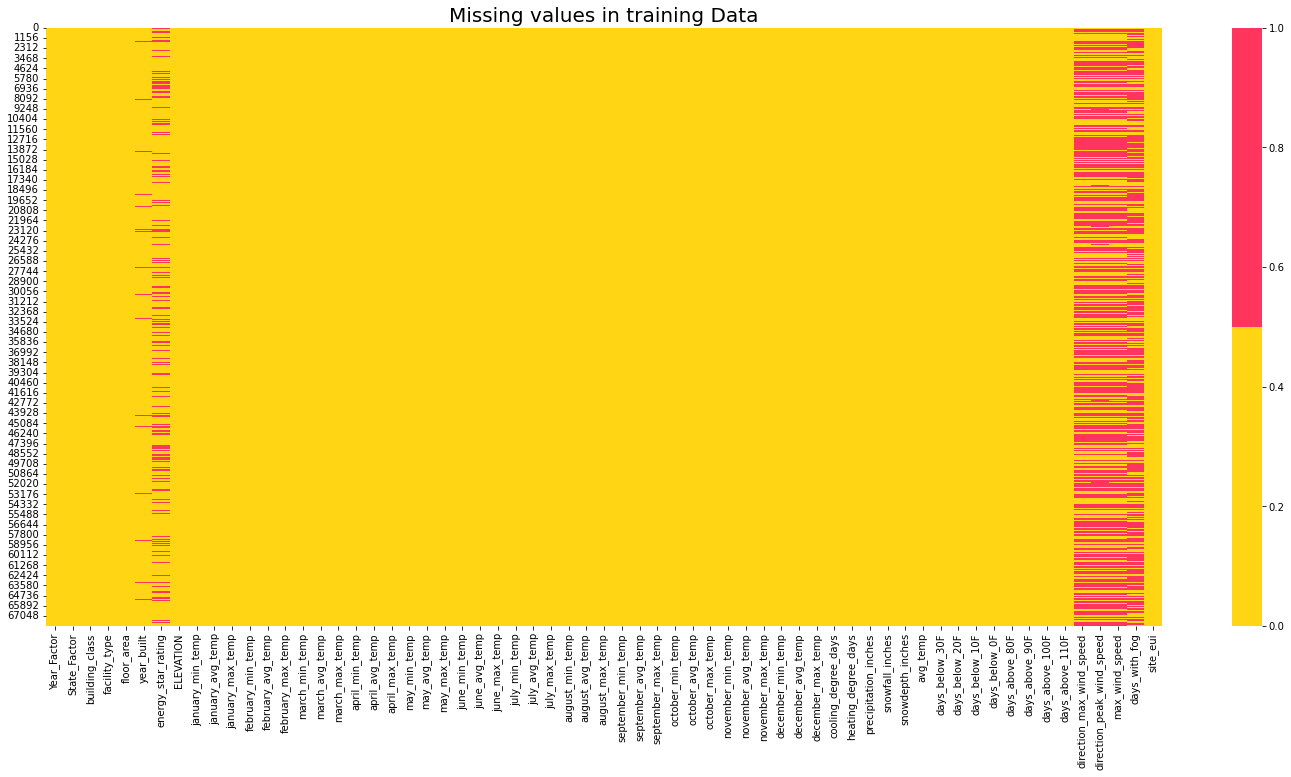

In [862]:
#Code from https://www.kaggle.com/usharengaraju/wids2022-lgbm-starter-w-b
plt.figure(figsize = (25,11))
sns.heatmap(train.isna().values, cmap = ['#ffd514','#ff355d'], xticklabels=train.columns)
plt.title("Missing values in training Data", size=20);

**Turning the viz into numbers below.**

In [897]:
#Code from https://www.kaggle.com/shrutisaxena/wids2022-starter-code
cols_with_missing = [col for col in train.columns 
                                 if train[col].isnull().any()]
miss_count =train.isna().sum()
miss_df = (pd.concat([miss_count.rename('Missing count'),miss_count.div(len(train)).rename('Missing value')],axis = 1).loc[miss_count.ne(0)])
miss_df.style.background_gradient(cmap="coolwarm")

,Missing count,Missing value
year_built,1663,0.024391
energy_star_rating,24061,0.352899
direction_max_wind_speed,37021,0.542981
direction_peak_wind_speed,37684,0.552705
max_wind_speed,37021,0.542981
days_with_fog,41224,0.604626


**Let's see which variables these missing values are most correlated to.**

In [864]:
num_train = train.select_dtypes(include=numerics)

corr = num_train.corr()
cols_no_missing = list(set(num_train.columns)-set(cols_with_missing))
cols_no_missing.sort()
corr_missing = corr.loc[cols_no_missing,cols_with_missing]

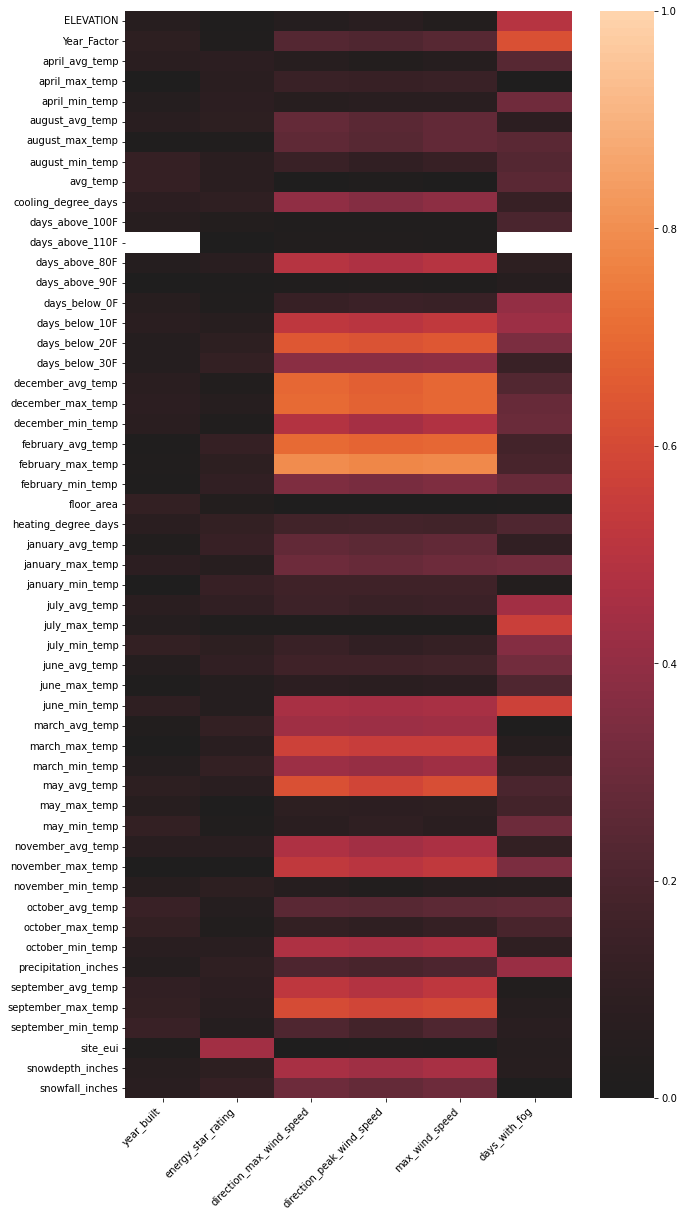

In [865]:
plt.figure(figsize = (10,20))
ax = sns.heatmap(
    abs(corr_missing),
    vmin=0, vmax=1, center=0,
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

- Wind speed columns are highly correlated to temperatures in Dec, Feb, and days below 10F and 20F. 
- energy_star_rating is correlated to site_eui
- days_with_fog is loosely correlated to june/july temps and year_factor and elevation
- year_built isn't highly correlated to anything

<a href='#eda'>Go to start of section </a>

<hr></hr>

<a id='features'></a>
# SECTION 2: Feature Engineering

**Below, I create a few new features for the dataset.**
1. <a href='#year_built'>Bucketing Year Built into Categories  </a>

2. <a href='#deviation'>Deviation from Room Temperature </a>

3. <a href='#building'>Grouping Building Categories </a>

4. <a href='#region'>Create Building Clusters </a>

5. <a href='#extreme'>Extreme Temperature Variable </a>

6. <a href='#area_elevation'>Area x Elevation </a>

7. <a href='#lag'>Lagged Features </a>

<a id='year_built'></a>
## 1. Bucketing Year Built into Categories 

In [1086]:
df = train

1663

array([[<AxesSubplot:title={'center':'year_built'}>]], dtype=object)

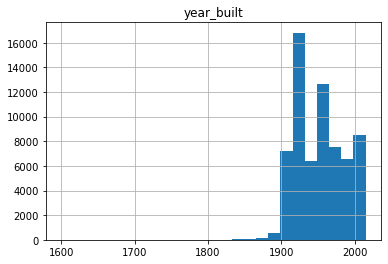

In [785]:
#Create new column for year 
df.hist(column='year_built',bins=25)

In [1093]:
def label_year(row):
    if row['year_built'] < 1900:
        return 'pre-1900'
    if row['year_built'] >= 1900 and row['year_built'] < 1920:
        return '1900-1920'
    if row['year_built'] >= 1920 and row['year_built'] < 1940:
        return '1920-1940'
    if row['year_built'] >= 1940 and row['year_built'] < 1960:
        return '1940-1960'
    if row['year_built'] >= 1960 and row['year_built'] < 1980:
        return '1960-1980'
    if row['year_built'] >= 1980 and row['year_built'] < 2000:
        return '1980-2000'
    if row['year_built'] >= 2000:
        return 'post-2000'
    if math.isnan(row['year_built']):
        return 'NaN'

df.loc[:,'year_built_cat'] = df.apply (lambda row: label_year(row), axis=1)
df.shape

(68181, 86)

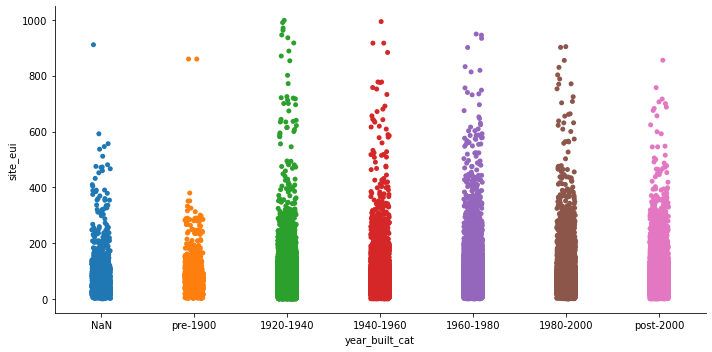

In [1095]:
sns.catplot(x="year_built_cat", 
            y="site_eui", 
            data=df, 
            height=5, 
            aspect=2,
            order = ['NaN','pre-1900','1920-1940','1940-1960','1960-1980','1980-2000','post-2000'])

<a id='deviation'></a>

## 2. Deviation from Room Temp

In [788]:
import calendar
def label_deviation(row,month):
    col = month.lower() + '_avg_temp'
    month_no = list(calendar.month_abbr).index(month[:3])
    days = calendar.monthrange(2022,month_no)[1]
    return (68-row[col])*days

In [789]:
for i in range(1,13):
    month = calendar.month_name[i]
    new_col = 'deviation_' + month
    df.loc[:,new_col] = df.apply (lambda row: label_deviation(row,month), axis=1)

In [790]:
df.shape

(68181, 76)

In [791]:
keys = [c for c in df if c.startswith('deviation_')]
df_melt = pd.melt(df, id_vars='site_eui', value_vars=keys, value_name='key')
d=deque(df_melt.variable.unique()[::-1])

Text(0.5, 1.0, "['deviation_May', 'deviation_April', 'deviation_March']")

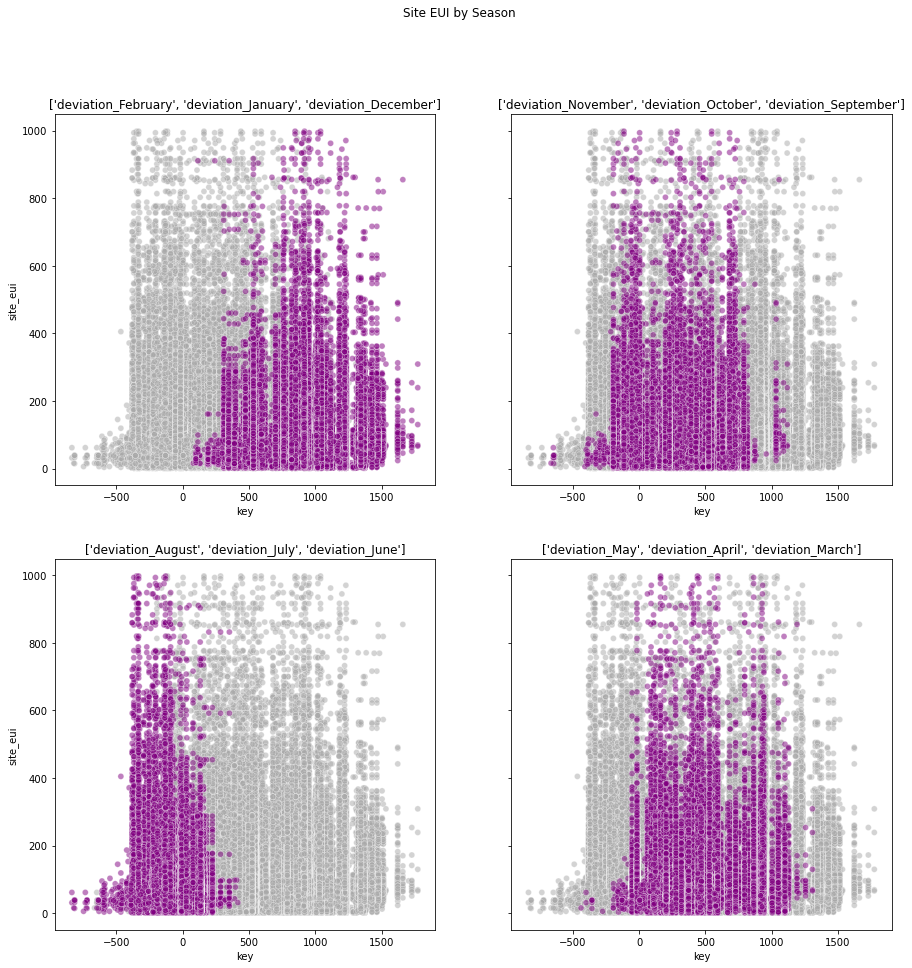

In [792]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
fig.suptitle('Site EUI by Season')

#Winter
d.rotate(-1)
hue_order = list(d)
palette = {c:'purple' if c in list(d)[-3:] else 'darkgrey' for c in list(d)}
sns.scatterplot(
    ax = axes[0,0],
    data=train_melt.sort_values('variable', key=np.vectorize(hue_order.index)),
    x='key', 
    y='site_eui', 
    hue='variable', 
    hue_order = hue_order, 
    legend=None, 
    palette=palette,
    alpha=0.5)
axes[0,0].set_title(list(d)[-3:])

#Fall
d.rotate(-3)
hue_order = list(d)
palette = {c:'purple' if c in list(d)[-3:] else 'darkgrey' for c in list(d)}
sns.scatterplot(
    ax = axes[0,1],
    data=train_melt.sort_values('variable', key=np.vectorize(hue_order.index)),
    x='key', 
    y='site_eui', 
    hue='variable', 
    hue_order = hue_order, 
    legend=None, 
    palette=palette,
    alpha=0.5)
axes[0,1].set_title(list(d)[-3:])

#Summer
d.rotate(-3)
hue_order = list(d)
palette = {c:'purple' if c in list(d)[-3:] else 'darkgrey' for c in list(d)}
sns.scatterplot(
    ax = axes[1,0],
    data=train_melt.sort_values('variable', key=np.vectorize(hue_order.index)),
    x='key', 
    y='site_eui', 
    hue='variable', 
    hue_order = hue_order, 
    legend=None, 
    palette=palette,
    alpha=0.5)
axes[1,0].set_title(list(d)[-3:])

#Spring
d.rotate(-3)
hue_order = list(d)
palette = {c:'purple' if c in list(d)[-3:] else 'darkgrey' for c in list(d)}
sns.scatterplot(
    ax = axes[1,1],
    data=train_melt.sort_values('variable', key=np.vectorize(hue_order.index)),
    x='key', 
    y='site_eui', 
    hue='variable', 
    hue_order = hue_order, 
    legend=None, 
    palette=palette,
    alpha=0.5)
axes[1,1].set_title(list(d)[-3:])

<a id='building'></a>
## 3. Grouping Building Categories

In [793]:
order = df.groupby('facility_type')['site_eui'].median().sort_values(ascending=False)
high_eui = order[:20].index
med_eui = order[20:40].index
low_eui = order[40:60].index

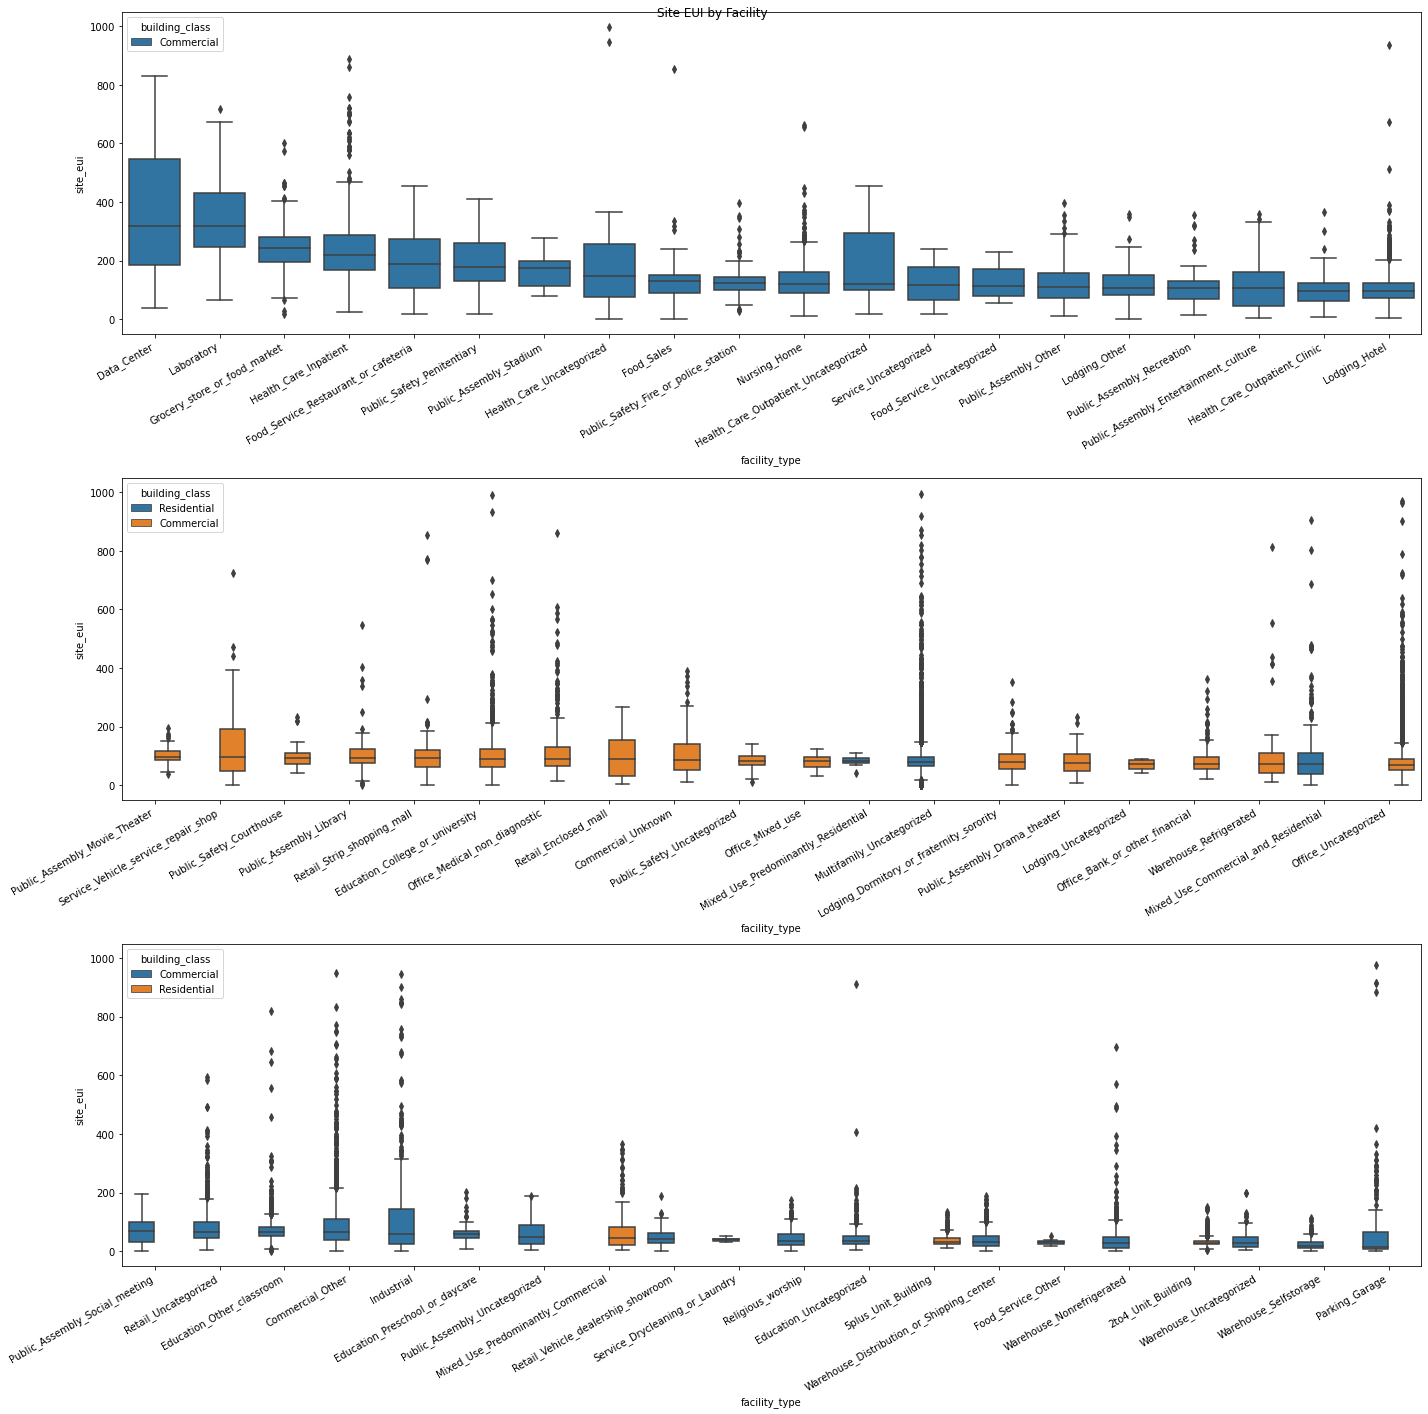

In [794]:
fig, axes = plt.subplots(3,1, figsize=(20,20), sharey=True)
fig.suptitle('Site EUI by Facility')
sns.boxplot(ax = axes[0],
            x="facility_type", 
            y="site_eui", 
            data=df[df['facility_type'].isin(high_eui)],
            hue = 'building_class',
            order = high_eui)

tix = axes[0].set_xticklabels(high_eui, rotation=30, ha='right')

sns.boxplot(ax = axes[1],
            x="facility_type", 
            y="site_eui", 
            data=df[df['facility_type'].isin(med_eui)],
            hue = 'building_class',
            order = med_eui)

tix = axes[1].set_xticklabels(med_eui, rotation=30, ha='right')

sns.boxplot(ax = axes[2],
            x="facility_type", 
            y="site_eui", 
            data=df[df['facility_type'].isin(low_eui)],
            hue = 'building_class',
            order = low_eui)

tix = axes[2].set_xticklabels(low_eui, rotation=30, ha='right')

fig.tight_layout()


In [795]:
# Create facility categories based on median temperature
eui_300above = order[:2].index
eui_250_180 = order[2:5].index
eui_160_140 = order[5:8].index
eui_140_110 = order[8:14].index
eui_110_90 = order[14:27].index
eui_90_70 = order[27:38].index
eui_70_50 = order[38:46].index
eui_50below = order[46:].index

In [796]:
eui_300above

Index(['Data_Center', 'Laboratory'], dtype='object', name='facility_type')

In [797]:
def label_facility(row):
    if row['facility_type'] in eui_300above:
        return 'eui_300above'
    if row['facility_type'] in eui_250_180:
        return 'eui_250_180'
    if row['facility_type'] in eui_160_140:
        return 'eui_160_140'
    if row['facility_type'] in eui_140_110:
        return 'eui_140_110'
    if row['facility_type'] in eui_110_90:
        return 'eui_110_90'
    if row['facility_type'] in eui_90_70:
        return 'eui_90_70'
    if row['facility_type'] in eui_70_50:
        return 'eui_70_50'   
    if row['facility_type'] in eui_50below:
        return 'eui_50below' 
    else:
        return 'other'

df.loc[:,'facility_cat'] = df.apply (lambda row: label_facility(row), axis=1)

In [798]:
df.shape

(68181, 77)

<a id='region'></a>

## 4. Create Building Clusters

**First, we will do PCA on our data since it is highly dimensional. Then, we will create the clusters. 
Link to [article](https://365datascience.com/tutorials/python-tutorials/pca-k-means/).**

In [799]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

sub_df = df[['ELEVATION', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'deviation_January',
       'deviation_February', 'deviation_March', 'deviation_April',
       'deviation_May', 'deviation_June', 'deviation_July', 'deviation_August',
       'deviation_September', 'deviation_October', 'deviation_November',
       'deviation_December']]

sub_df.shape

(68181, 27)

In [800]:
sc = StandardScaler()
sc.fit(sub_df.values)
scaled_features = sc.transform(sub_df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=sub_df.index, columns=sub_df.columns)
scaled_features_df.shape

(68181, 27)

In [801]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(scaled_features_df)

<BarContainer object of 20 artists>

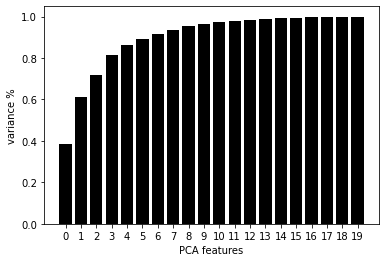

In [802]:
features = range(pca.n_components_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.bar(features, pca.explained_variance_ratio_.cumsum(), color='black')

A rule of thumb is to preserve around 80 % of the variance. So, in this instance, we decide to keep 4 components.

In [803]:
pca = PCA(n_components=4)
pca.fit(scaled_features_df)
scores_pca = pca.transform(scaled_features_df)
scores_pca.shape

(68181, 4)

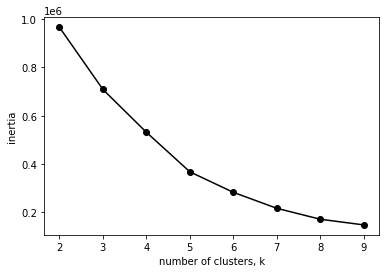

In [804]:
ks = range(2, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, init='k-means++')
    
    # Fit model to samples
    model.fit(scores_pca)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

We can choose 5 number of clusters as this is the elbow point. Now, we run k-means where the number of clusters is 5. 

In [805]:
model = KMeans(n_clusters=5, init='k-means++')
model.fit(scores_pca)

KMeans(n_clusters=5)

In [806]:
df.loc[:,['Component 1', 'Component 2', 'Component 3','Component 4']] = scores_pca

In [807]:
df.loc[:,'Kmeans clusters'] = model.labels_

In [808]:
df.shape

(68181, 82)

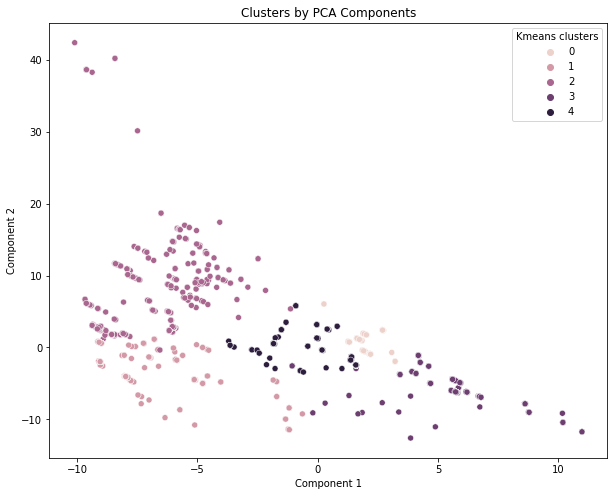

In [809]:
x = train['Component 1']
y = train['Component 2']
plt.figure(figsize = (10,8))
sns.scatterplot(x= x, y = y, hue = df['Kmeans clusters'])
plt.title('Clusters by PCA Components')
plt.show()

<a id='extreme'></a>
## 5. Extreme Temperature Variable

This will be based on days below 30F and days above 110F.

In [810]:
df.loc[:,'extreme_temp_days'] = df['days_below_30F'] + df['days_above_110F']
df.shape

(68181, 83)

<a id='area_elevation'></a>

## 6. Area x Elevation

In [811]:
df.loc[:,'area_elevation'] = df['floor_area'] * df['ELEVATION']
df.shape

(68181, 84)

<a id='lag'></a>

## 7. Lagged Site EUI Feature

**Credit to the winning team for this feature idea.**

In [812]:
sub_df=df
cols1 = ['State_Factor','building_class','facility_type','floor_area','year_built']
sub_df=sub_df.sort_values(by=cols1+ ['Year_Factor'])
sub_df['site_eui_lag1']=sub_df.groupby(cols1)['site_eui'].shift(1)
sub_df.shape

(68181, 85)

In [813]:
df = df.join(sub_df['site_eui_lag1'])
df.shape

(68181, 85)

In [1059]:
df['site_eui_lag1'].isna().sum() 

25953

# Combine all of this into one function

In [1245]:
def create_features(data, train, is_train = True, sc= StandardScaler(), pca = PCA(n_components=4)):
    #Year Categories 
    data.loc[:,'year_built_cat'] = data.apply (lambda row: label_year(row), axis=1)
    
    #Deviation from Room Temp
    for i in range(1,13):
        month = calendar.month_name[i]
        new_col = 'deviation_' + month
        data.loc[:,new_col] = data.apply (lambda row: label_deviation(row,month), axis=1)
    
    #Facility type
    data.loc[:,'facility_cat'] = data.apply (lambda row: label_facility(row), axis=1)
    
    #Building Clusters
    df = data[['ELEVATION', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'deviation_January',
       'deviation_February', 'deviation_March', 'deviation_April',
       'deviation_May', 'deviation_June', 'deviation_July', 'deviation_August',
       'deviation_September', 'deviation_October', 'deviation_November',
       'deviation_December']].copy()
    
    if is_train:
        sc.fit(df.values)
        pca.fit(sc.transform(df.values))
        
    scores_pca = pca.transform(sc.transform(df.values)) 
    model = KMeans(n_clusters=5, init='k-means++')
    model.fit(scores_pca)
    data.loc[:,['Component 1', 'Component 2', 'Component 3','Component 4']] = scores_pca
    data.loc[:,'Kmeans clusters'] = model.labels_
    
    #Extreme Temp Variation
    data.loc[:,'extreme_temp_days'] = data['days_below_30F'] + data['days_above_110F']
    
    #Area x Elevation
    data.loc[:,'area_elevation'] = data['floor_area'] * data['ELEVATION']
    
    #Lagged Site EUI Feature
    if is_train:
        df_pivot = pd.pivot_table(data,index=cols+['Year_Factor'],values='site_eui')
    else:
        df_pivot = pd.pivot_table(train,index=cols+['Year_Factor'],values='site_eui')
    data.loc[:,'last_year_factor'] = data['Year_Factor']-1
    data.loc[:,'id'] = data.index
    data = pd.merge(data, df_pivot,  how='left', left_on=cols+['last_year_factor'], right_on = cols+['Year_Factor'])
    data.set_index('id',inplace=True)
    data.rename(columns={"site_eui":"site_eui_lag1","site_eui_x": "site_eui", "site_eui_y":"site_eui_lag1"}, inplace=True)
    return data, sc, pca

<a href='#features'>Go to start of section </a>

<hr></hr>

<a id='methods'></a>
# SECTION 3: Methods to deal with missing data

**Below, I will go into two different ways of dealing with missing data.**
1. <a href='#impute1'>Simple Imputer with Median </a>
    
2. <a href='#impute2'>Predictive Model Based Imputation </a>

<a id='impute1'></a>
## 1. Simple Imputer

In [695]:
from sklearn.impute import SimpleImputer

#One hot code the data
train_encoded = pd.get_dummies(train)

my_imputer = SimpleImputer(strategy='median', missing_values=np.nan)
simple_impute_train = pd.DataFrame(my_imputer.fit_transform(train_encoded),columns = train_encoded.columns, index=train_encoded.index)
print ("Number of NAs:", simple_impute_train.isna().sum().sum())

Number of NAs: 0


<a id='impute2'></a>
## 2. Predictive Model Based Imputation

- https://medium.com/swlh/impute-missing-values-the-right-way-c63735fccccd
- https://github.com/catboost/tutorials/blob/master/feature_selection/select_features_tutorial.ipynb
- https://arxiv.org/abs/2010.00718

In [869]:
#Define a function to select features 
def impute_data(target_var, target_train, target_test, num_features_to_select,iterations=1000):
    
    #Select features for our imputation model
    feature_names = list(target_train.drop(target_var,axis=1).columns)
    cat_features = list(target_train.select_dtypes(include=['object']).columns)
    train_pool = Pool(target_train.drop(target_var,axis=1), target_train[target_var], cat_features =cat_features )
    test_pool = Pool(target_test.drop(target_var,axis=1), target_test[target_var], cat_features=cat_features)
    
    model = CatBoostRegressor(iterations=iterations, colsample_bylevel = 0.5,learning_rate = 0.1,depth =4, early_stopping_rounds=10)
    
    summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=list(range(target_train.shape[1]-1)),
    num_features_to_select=num_features_to_select,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level='Silent',
    plot=True
    )
    
    
    #Find optimal hyperparameters
    cat_features = list(target_train.drop(target_var,axis=1)[summary['selected_features_names']].select_dtypes(include=['object']).columns)
    train_pool = Pool(target_train.drop(target_var,axis=1)[summary['selected_features_names']],target_train[target_var],cat_features=cat_features)

    grid = {'depth':[int(x) for x in np.linspace(2, 10, num = 5)],
        'iterations':[int(x) for x in np.linspace(200, 1000, num = 5)],
        'learning_rate':[0.001,0.05,0.1], 
        'l2_leaf_reg':[0.2, 0.5, 1,3,5],
        'colsample_bylevel':[0.5,0.75,1.0],
        'random_strength':[int(x) for x in np.linspace(0, 10, num = 6)],
        'early_stopping_rounds':[10,50,100]
       }

    cat = CatBoostRegressor(loss_function='RMSE',logging_level='Silent')

    randomized_search_result = cat.randomized_search(grid, train_pool,plot=False)
    print('selected best parameters!')
    
    #Train model with selected features and selected hyperparameters
    cat = CatBoostRegressor(**randomized_search_result['params'])
    cat.fit(train_pool,verbose=False, plot=False)
    test_predict = cat.predict(target_test.drop(target_var,axis=1)[summary['selected_features_names']])
    return cat, test_predict, summary


In [845]:
#Define a function to calculate the RMSE 
def rmse(a,p):
    return np.sqrt(mse(a,p))

<a id='energy_star_rating'></a>

### Energy Star Rating 

**We're only going to impute energy star rating as it had the highest correlation to Site EUI.**

In [1031]:
len(train), train['energy_star_rating'].isna().sum()

(68181, 24061)

In [1063]:
pd.options.mode.chained_assignment = None  # default='warn'
target_var = 'energy_star_rating'

df_na = train.copy()

#Fill all other NaNs with 0 
df_na[['year_built','max_wind_speed','direction_max_wind_speed','direction_peak_wind_speed','days_with_fog']] = df_na[['year_built','max_wind_speed','direction_max_wind_speed','direction_peak_wind_speed','days_with_fog']].fillna(0)

#All rows where the variable is NA go into target_missing; the rest go into target_present
target_missing = df_na.loc[df_na[target_var].isnull()==True].copy()
target_present = df_na.loc[df_na[target_var].isnull()==False].copy()

target_missing.shape, target_present.shape

((24061, 63), (44120, 63))

In [1034]:
#Set aside some data to test the imputation model
target_train, target_test = train_test_split(target_present, test_size=0.1, random_state=42)

#Create new features and drop site EUI from the imputation model
target_train, sc, pca = create_features(target_train, train, is_train = True)
target_test, _ , _ = create_features(target_test, train, is_train = False, sc = sc, pca = pca)

target_train.drop('site_eui',axis=1,inplace=True)
target_test.drop('site_eui',axis=1,inplace=True)

target_train.shape, target_test.shape

((39708, 85), (4412, 85))

In [1035]:
cat_energy, test_predict_energy, summary_energy = impute_data(target_var, target_train, target_test, num_features_to_select=15)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 24.6272834	best: 24.6272834 (0)	total: 22.8s	remaining: 3m 25s
1:	loss: 24.8060471	best: 24.6272834 (0)	total: 37.6s	remaining: 2m 30s
2:	loss: 24.1181820	best: 24.1181820 (2)	total: 1m	remaining: 2m 21s
3:	loss: 34.0981617	best: 24.1181820 (2)	total: 2m 22s	remaining: 3m 33s
4:	loss: 35.3038475	best: 24.1181820 (2)	total: 3m 19s	remaining: 3m 19s
5:	loss: 57.1540325	best: 24.1181820 (2)	total: 3m 30s	remaining: 2m 20s
6:	loss: 24.1657900	best: 24.1181820 (2)	total: 4m 9s	remaining: 1m 47s
7:	loss: 24.0759256	best: 24.0759256 (7)	total: 4m 42s	remaining: 1m 10s
8:	loss: 24.2345776	best: 24.0759256 (7)	total: 5m 5s	remaining: 33.9s
9:	loss: 23.8665260	best: 23.8665260 (9)	total: 6m 32s	remaining: 0us
Estimating final quality...
selected best parameters!


In [1036]:
print("RMSE of holdout data is ", round(rmse(target_test[target_var],test_predict_energy),2))

RMSE of holdout data is  22.73


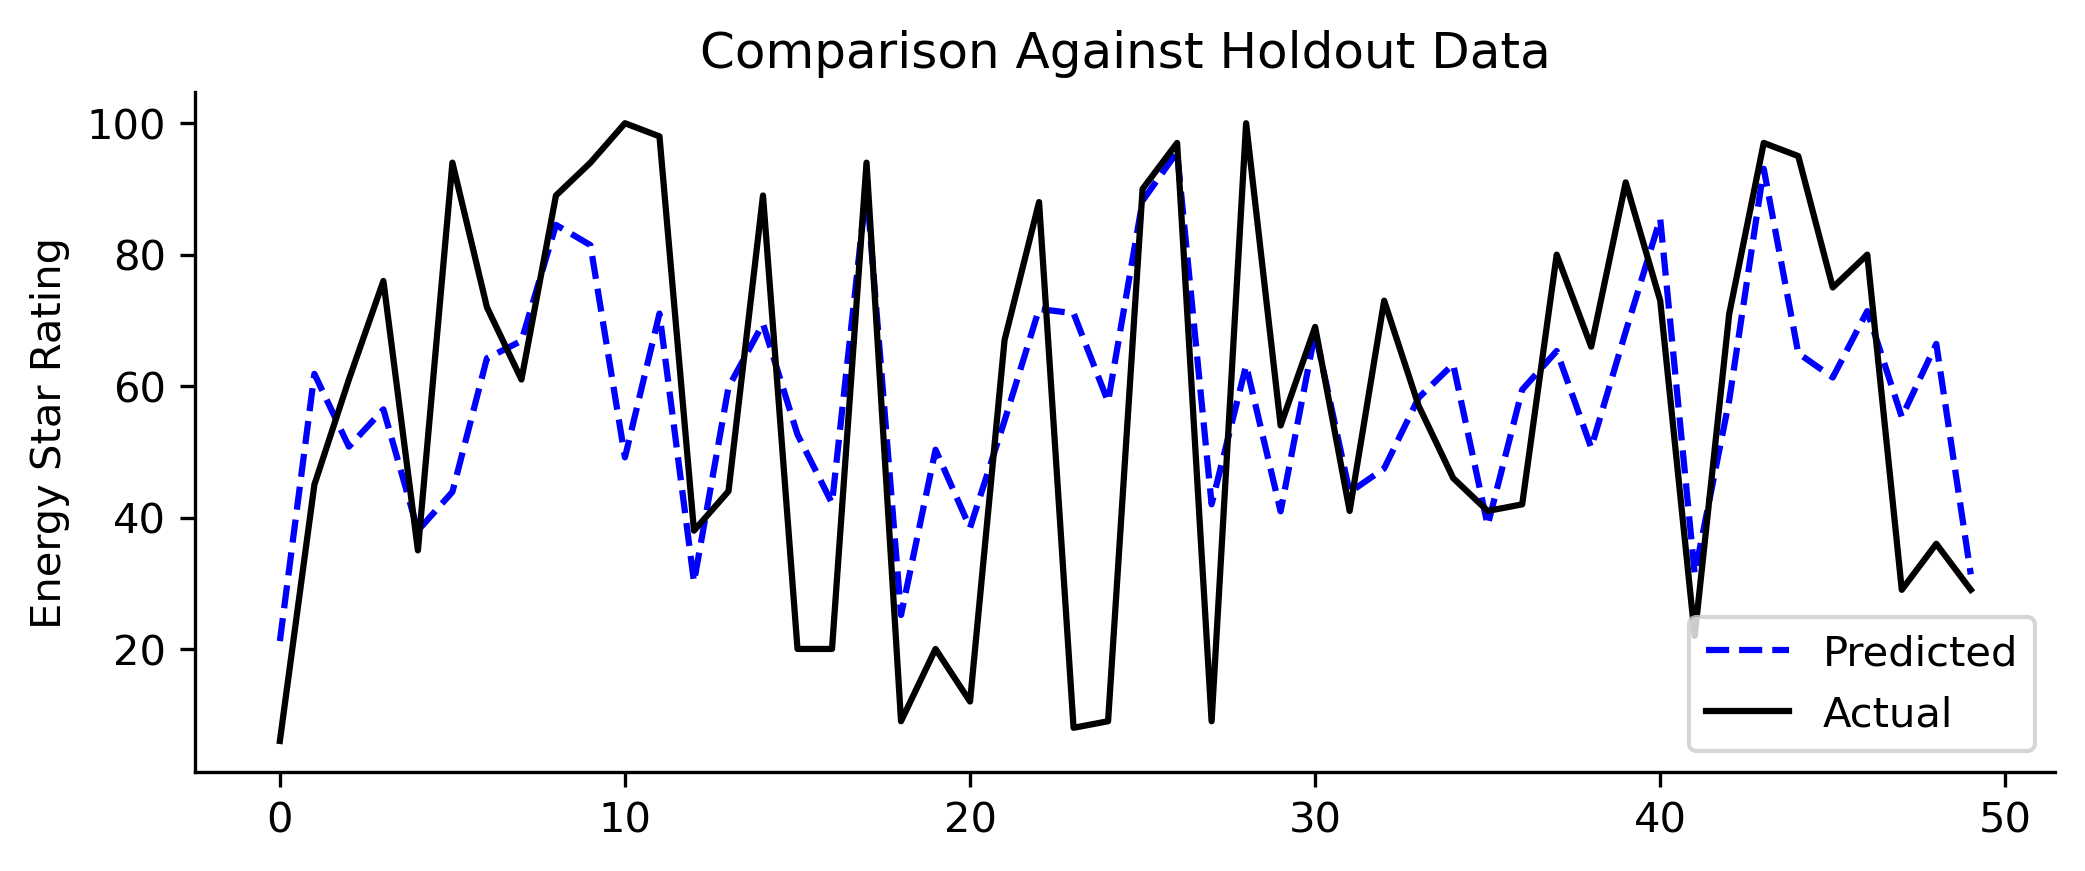

In [1038]:
fig = plt.figure(figsize=(8,3),dpi=300)
plt.plot(range(0,len(test_predict_energy[50:100])),test_predict_energy[50:100],'b--',label = 'Predicted')
plt.plot(range(0,len(target_test['energy_star_rating'][50:100])),target_test['energy_star_rating'][50:100],'k-',label = 'Actual')
plt.ylabel('Energy Star Rating')
plt.legend()
plt.title('Comparison Against Holdout Data')
sns.despine()
plt.show()

**Impute missing data with model.**

In [1069]:
target_missing = df_na.loc[df_na[target_var].isnull()==True].copy()
target_missing.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
id,,,,,,,,,,,,,,,,,,,,,
57703,6,State_6,Residential,Multifamily_Uncategorized,72888.0,1927.0,NaN,42.7,11,34.451613,...,1,96,17,0,0,0.0,0.0,0.0,131.0,87.959016
34408,4,State_6,Residential,Multifamily_Uncategorized,147088.0,1960.0,NaN,3.4,4,28.596774,...,0,75,4,0,0,1.0,1.0,1.0,0.0,74.003361
49532,5,State_6,Residential,Multifamily_Uncategorized,50714.0,1989.0,NaN,42.7,8,29.854839,...,0,106,12,0,0,310.0,310.0,13.0,110.0,104.105928
21794,2,State_6,Residential,Multifamily_Uncategorized,102881.0,1929.0,NaN,3.4,13,37.322581,...,0,72,17,0,0,1.0,1.0,1.0,79.0,68.289597
9634,6,State_2,Commercial,Office_Uncategorized,233081.0,1982.0,NaN,3.0,11,32.000000,...,0,109,38,0,0,0.0,0.0,0.0,0.0,39.879436


In [1073]:
target_missing, _ , _ = create_features(target_missing, train, is_train = False, sc = sc, pca = pca)
target_missing.isna().sum()

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
year_built                       0
energy_star_rating           24061
ELEVATION                        0
january_min_temp                 0
january_avg_temp                 0
january_max_temp                 0
february_min_temp                0
february_avg_temp                0
february_max_temp                0
march_min_temp                   0
march_avg_temp                   0
march_max_temp                   0
april_min_temp                   0
april_avg_temp                   0
april_max_temp                   0
may_min_temp                     0
may_avg_temp                     0
may_max_temp                     0
june_min_temp                    0
june_avg_temp                    0
june_max_temp                    0
july_min_temp                    0
july_avg_temp                    0
july_max_temp       

In [1074]:
target_missing[target_var] = cat_energy.predict(target_missing.drop(target_var,axis=1)[summary_energy['selected_features_names']])

In [1075]:
train.loc[train[target_var].isna(),target_var]= target_missing[target_var]

In [1076]:
train[target_var].isna().sum()

0

In [1077]:
train.isna().sum()

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
year_built                    1663
energy_star_rating               0
ELEVATION                        0
january_min_temp                 0
january_avg_temp                 0
january_max_temp                 0
february_min_temp                0
february_avg_temp                0
february_max_temp                0
march_min_temp                   0
march_avg_temp                   0
march_max_temp                   0
april_min_temp                   0
april_avg_temp                   0
april_max_temp                   0
may_min_temp                     0
may_avg_temp                     0
may_max_temp                     0
june_min_temp                    0
june_avg_temp                    0
june_max_temp                    0
july_min_temp                    0
july_avg_temp                    0
july_max_temp       

<a href='#methods'>Go to start of section </a>

<a id='models'></a>
# SECTION 4: Model Development

**These are the steps we will take in this section to develop out model:**

1. <a href='#featselect'>Feature Selection / Tuning Hyperparameters </a>
2. <a href='#train'>Train Model </a>
3. <a href='#eval'>Evaluate </a>
4. <a href='#submit'>Create Submission </a>

<a id='featselect'></a>

## 1. Feature Selection / Tuning Hyperparameters

### 1.2 Feature Selection

In [ ]:
params = {'random_strength': 10,
 'depth': 8,
 'od_wait': 10,
 'l2_leaf_reg': 5,
 'iterations': 800,
 'rsm': 0.5,
 'learning_rate': 0.1,
 'logging_level':'Silent'
    }

In [1100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68181 entries, 57703 to 15795
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                68181 non-null  int64  
 1   State_Factor               68181 non-null  object 
 2   building_class             68181 non-null  object 
 3   facility_type              68181 non-null  object 
 4   floor_area                 68181 non-null  float64
 5   year_built                 66518 non-null  float64
 6   energy_star_rating         44120 non-null  float64
 7   ELEVATION                  68181 non-null  float64
 8   january_min_temp           68181 non-null  int64  
 9   january_avg_temp           68181 non-null  float64
 10  january_max_temp           68181 non-null  int64  
 11  february_min_temp          68181 non-null  int64  
 12  february_avg_temp          68181 non-null  float64
 13  february_max_temp          68181 non-null 

In [1143]:
cat = CatBoostRegressor(**params)

In [1165]:
train.shape

(68181, 63)

In [1174]:
def cv_results(train, threshold = 0.3):
    kf = KFold(n_splits = 5, random_state = 1, shuffle = True)
    oof_preds = np.zeros(train.shape[0])
    oof_rmse = []
    selected_features_kf = [] 
    for i, (train_index, val_index) in enumerate(kf.split(train)):
        train_set, val_set = train.iloc[train_index], train.iloc[val_index]
        print( "\nFold ", i)

        #Generate features for train and val separately 
        train_set, sc, pca = create_features(train_set, train_set, is_train = True )
        val_set, _ , _ = create_features(val_set, train_set, is_train = False, sc= sc, pca=pca) 
        print ('Created features.')

        X_train = train_set.drop('site_eui',axis=1)
        y_train = train_set['site_eui']
        X_val = val_set.drop('site_eui',axis=1)
        y_val = val_set['site_eui']

        #Fit Model with all features
        cat_features = list(X_train.select_dtypes(include=['object']).columns)
        train_pool = Pool(X_train, label = y_train,
                      cat_features = cat_features)

        val_pool = Pool(X_val, label = y_val, 
                     cat_features = cat_features)
        cat.fit(train_pool,eval_set = val_pool, verbose=False, plot=False)
        print ('Trained model with all features.') 

        #Collect SHAP values and use only features that have SHAP > threshold
        explainer = shap.TreeExplainer(cat)
        shap_values = explainer.shap_values(X_val)
        selected_features = X_train.columns[np.where(np.abs(shap_values).mean(0)>threshold)]
        selected_features_kf.append(selected_features)

        #Retrain model with selected features
        cat_features = list(X_train[selected_features].select_dtypes(include=['object']).columns)
        train_pool = Pool(X_train[selected_features], label = y_train,
                      cat_features = cat_features)

        val_pool = Pool(X_val[selected_features], label = y_val, 
                     cat_features = cat_features)
        cat.fit(train_pool,eval_set = val_pool, verbose=False, plot=False)
        print ('Trained model with selected features.')

        #Get OOF predictions with selected features 
        oof_preds[val_index] = cat.predict(X_val[selected_features])
        oof_rmse.append(rmse(y_val, oof_preds[val_index]))
    return oof_preds, oof_rmse, selected_features_kf

In [1175]:
oof_preds, oof_rmse, selected_features_kf = cv_results(train, 0.2)


Fold  0
Created features.
Trained model with all features.
Trained model with selected features.

Fold  1
Created features.
Trained model with all features.
Trained model with selected features.

Fold  2
Created features.
Trained model with all features.
Trained model with selected features.

Fold  3
Created features.
Trained model with all features.
Trained model with selected features.

Fold  4
Created features.
Trained model with all features.
Trained model with selected features.


In [1176]:
oof_rmse, np.mean(oof_rmse)

([36.756255579383705,
  38.97238133422578,
  37.37434892446552,
  37.71717393470403,
  39.17730655643585],
 37.99949326584298)

In [1206]:
import itertools
feat = list(itertools.chain.from_iterable(selected_features_kf))

In [1207]:
import collections
frequency = dict(collections.Counter(feat))
feat = pd.DataFrame(list(frequency.items()),columns = ['Feature','Frequency'])

In [1219]:
feat.sort_values(by='Frequency',ascending=False)

,Feature,Frequency
20,snowdepth_inches,5
13,march_max_temp,5
31,facility_cat,5
25,year_built_cat,5
24,days_with_fog,5
32,Component 1,5
33,Component 2,5
34,Component 3,5
19,snowfall_inches,5
35,Component 4,5


### 1.2 Fine Tune Hyperparameters

In [1220]:
#Choose features that appear in at least 3 of the folds 
selected_features = feat[feat['Frequency']>=3]['Feature']
selected_features

0            Year_Factor
1           State_Factor
2         building_class
3          facility_type
4             floor_area
5             year_built
6     energy_star_rating
7              ELEVATION
8       january_min_temp
11     february_min_temp
13        march_max_temp
15         july_avg_temp
16       august_avg_temp
17     november_max_temp
19       snowfall_inches
20      snowdepth_inches
21        days_below_30F
22        days_below_20F
23        days_above_80F
24         days_with_fog
25        year_built_cat
28        deviation_June
29        deviation_July
31          facility_cat
32           Component 1
33           Component 2
34           Component 3
35           Component 4
36        area_elevation
37      last_year_factor
38         site_eui_lag1
39     february_avg_temp
40        april_min_temp
41         july_min_temp
43     december_max_temp
46       deviation_March
54       Kmeans clusters
Name: Feature, dtype: object

In [1224]:
train_set, sc, pca = create_features(train, train, is_train = True)

In [1225]:
cat_features = list(train_set[selected_features].select_dtypes(include=['object']).columns)
train_pool = Pool(data = train_set[selected_features], label = train_set['site_eui'], cat_features = cat_features)

In [1226]:
#Tune hyperparameters
grid = {'depth':[int(x) for x in np.linspace(2, 10, num = 5)],
        'iterations':[int(x) for x in np.linspace(200, 1000, num = 5)],
        'learning_rate':[0.001,0.005,0.01,0.05,0.1], 
        'l2_leaf_reg':[0.2, 0.5, 1,3,5],
        'colsample_bylevel':[0.5,0.75,1.0],
        'random_strength':[int(x) for x in np.linspace(0, 10, num = 6)],
        'early_stopping_rounds':[10,50,100]
       }

cat = CatBoostRegressor(loss_function='RMSE',logging_level='Silent')

randomized_search_result = cat.randomized_search(grid, train_pool, n_iter = 20, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1228]:
randomized_search_result['params']

{'random_strength': 0,
 'depth': 10,
 'od_wait': 50,
 'l2_leaf_reg': 1,
 'iterations': 200,
 'rsm': 1.0,
 'learning_rate': 0.1}

<a id='train'></a>

## 2. Train Model

In [1229]:
#Train model with selected features and selected hyperparameters over entire training set 
cat = CatBoostRegressor(**randomized_search_result['params'])
cat.fit(train_pool,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<a id='eval'></a>

## 3. Evaluate Model on Test Data

In [1232]:
test_set, _, _  = create_features(test, train, is_train=False, sc = sc, pca = pca)

In [1233]:
y_test_predict = cat.predict(test_set[selected_features])
rmse(test_set['site_eui'], y_test_predict)

39.07405024612156

<a id='submit'></a>

## 4. Create Submission

In [1258]:
X_submission = pd.read_csv('test.csv',index_col='id')
X_submission.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
id,,,,,,,,,,,,,,,,,,,,,
75757,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,0,29,5,2,0,NaN,NaN,NaN,NaN
75758,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,0,29,5,2,0,NaN,NaN,NaN,NaN
75759,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,0,29,5,2,0,NaN,NaN,NaN,NaN
75760,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,0,0,29,5,2,0,NaN,NaN,NaN,NaN
75761,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,0,0,29,5,2,0,340.0,330.0,22.8,126.0


In [1259]:
submission_idx = X_submission.index

In [1260]:
X_submission.shape

(9705, 62)

In [1261]:
pd.options.display.max_rows = 999
X_submission.isna().sum()

Year_Factor                     0
State_Factor                    0
building_class                  0
facility_type                   0
floor_area                      0
year_built                     92
energy_star_rating           2254
ELEVATION                       0
january_min_temp                0
january_avg_temp                0
january_max_temp                0
february_min_temp               0
february_avg_temp               0
february_max_temp               0
march_min_temp                  0
march_avg_temp                  0
march_max_temp                  0
april_min_temp                  0
april_avg_temp                  0
april_max_temp                  0
may_min_temp                    0
may_avg_temp                    0
may_max_temp                    0
june_min_temp                   0
june_avg_temp                   0
june_max_temp                   0
july_min_temp                   0
july_avg_temp                   0
july_max_temp                   0
august_min_tem

In [1262]:
#Create features 
X_submission_features, _ , _  = create_features(X_submission, train, is_train = False, sc = sc, pca = pca)

In [1263]:
X_submission_features.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,facility_cat,Component 1,Component 2,Component 3,Component 4,Kmeans clusters,extreme_temp_days,area_elevation,last_year_factor,site_eui_lag1
id,,,,,,,,,,,,,,,,,,,,,
75757,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,eui_250_180,-8.257239,-0.801061,3.596721,0.333939,4,0,68361.6,6,168.039617
75758,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,eui_250_180,-8.204357,-0.880800,3.650223,0.636229,4,0,1001104.2,6,272.553279
75759,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,eui_250_180,-8.187992,-0.905477,3.666780,0.729778,4,0,953755.8,6,151.983607
75760,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,eui_250_180,-8.216936,-0.861832,3.637496,0.564322,4,0,3448738.8,6,264.375683
75761,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,eui_250_180,-8.257971,-0.799956,3.595980,0.329750,4,0,110235.6,6,242.535519


In [1264]:
#Impute missing values 
target_var = 'energy_star_rating'
target_missing = X_submission_features.loc[X_submission_features[target_var].isnull()==True].copy()
target_missing[target_var] = cat_energy.predict(target_missing.drop(target_var,axis=1)[summary_energy['selected_features_names']])
X_submission_features.loc[X_submission_features[target_var].isna(),target_var]= target_missing[target_var]

In [1270]:
pred = cat.predict(X_submission_features[selected_features])
submission = pd.DataFrame(pred, index= X_submission.index, columns= ['site_eui'])
submission.head()

,site_eui
id,
75757,205.390050
75758,264.624701
75759,184.545922
75760,253.667059
75761,237.463005


In [1271]:
submission.to_csv('submission_NG.csv')

<a href='#models'>Go to start of section </a>

<a href='#start'>Go to start of notebook </a>